Start processing file : GVRP/A-n33-k5-C11-V2.gvrp
nNodes, nVehicles, nGroups, capacity :  33 2 11 100
nodes :  [[42 68  0]
 [77 97  2]
 [28 64  4]
 [77 39 10]
 [32 33  5]
 [32  8  5]
 [42 92  6]
 [ 8  3  1]
 [ 7 14  1]
 [82 17  3]
 [48 13  5]
 [53 82 11]
 [39 27  5]
 [ 7 24  1]
 [67 98  2]
 [54 52  8]
 [72 43 10]
 [73  3  3]
 [59 77 11]
 [58 97  6]
 [23 43  9]
 [68 98  2]
 [47 62  8]
 [52 72 11]
 [32 88  6]
 [39  7  5]
 [17  8  1]
 [38  7  5]
 [58 74 11]
 [82 67  7]
 [42  7  5]
 [68 82 11]
 [ 7 48  9]]
groups :  [[0], [7, 8, 13, 26], [1, 14, 21], [9, 17], [2], [12, 4, 5, 10, 25, 27, 30], [6, 19, 24], [29], [15, 22], [32, 20], [3, 16], [18, 11, 23, 28, 31]]
globalDemands [13  8 21 23 15 15  8 18  5 12 14]
Ending processing file : GVRP/A-n33-k5-C11-V2


initial routes :  [[3, 5, 1, 10, 7, 8], [11, 2, 6, 9, 4]]
initial demand distribution :  [87, 65]
initial distances :  [261. 146.]
initial total distance :  407.0


nova rota thanks to 2opt !! :  [11, 2, 6, 4, 9] 143.0
new route thanks to

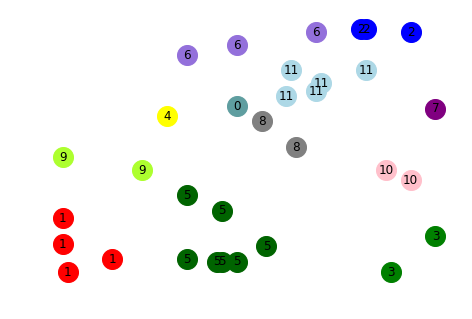

In [33]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Sep 12 22:46:37 2019

@author: andreamourelo
"""

from IPython.display import display, Markdown, Latex
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')
import csv
import numpy as np
import sys, getopt
import math
import random
import timeit
import os
import networkx as nx


instance = ''
nNodes = 0
nVehicles = 0
nGroups = 0
capacity = 0
nodes = []
groups = []
globalDemands = []
distances = []

######## FUNCTIONS

### Functions to process and print in log
def processFile(filename):
    '''No final, vamos ter:
    nodes = [node1, node2, ..., nodenNodes] = [[x_pos_node1, y_pos_node1, group_node_1], ....]
    com group_node entre [1, nGroups]
    e globalDemands = [demand_group_1, demand_group_2, ..., demand_group_nGroups] 
    
    Esta funcao calcula tambem a matriz de distâncias
    '''
    
    print('Start processing file :', filename)
    instance = filename[:-5]
    delimiter = ' '
    with open(filename,'r') as file:
        csv_reader = csv.reader(file,
                               delimiter = delimiter)
        line_count = 0
        node_count = 0
        group_count = 0
        nNodes, nGroups, nVehicles, capacity = 0,0,0,0
        for row in csv_reader:
            if line_count == 2 :  # DIMENSION : nNodes
                nNodes = int(row[2])
                nodes = np.zeros((nNodes,3), dtype=np.int)
            elif line_count == 3 : # VEHICLES : nVehicles
                nVehicles = int(row[2])
            elif line_count == 4 : # GVRP_SETS : nGroups
                nGroups = int(row[2])
                groups = [[0]] # Para guardar uma lista com os grupos
                globalDemands = np.zeros((nGroups), dtype=np.int)
            elif line_count == 5 :
                capacity = int(row[2]) # CAPACITY : capacity
            elif line_count >= 8 and line_count <= 8 + nNodes +  - 1: # Informacoes sobre as posicoes dos nos => num x_pos y_pos
                nodes[node_count] = [int(row[1]),int(row[2]), 0] # Ainda nao temos info sobre o grupo do nó, no depot vai ter grupo 0 
                node_count += 1
            elif line_count >= 8 + nNodes + 1 and line_count <= 8 + nNodes + nGroups: # Informacoes sobre os grupos => num_grupo elem elem ... elem -1
                nNodesInGroup = len(row)
                group = []
                for numNode in range(1,nNodesInGroup - 1 ): # Para evitar o "-1" que mostra quando pular linha
                    nodeOfGroup = int(row[numNode]) - 1
                    nodes[nodeOfGroup][2]  = group_count + 1
                    group.append(nodeOfGroup)
                group_count += 1
                groups.append(group)
                if group_count == nGroups:
                    group_count = 0  # Reseteando no final para usar na leitura seguinte
            elif line_count >= 8 + nNodes + nGroups + 2 and line_count <= 8 + nNodes + 2*(nGroups + 1) - 1:
                globalDemands[group_count] = int(row[1])
                group_count += 1
            line_count += 1

    print("nNodes, nVehicles, nGroups, capacity : ", nNodes, nVehicles, nGroups, capacity)
    print("nodes : ",nodes)
    print("groups : ",groups)
    print("globalDemands", globalDemands)  
    
    distances = np.full((nNodes,nNodes), 100000000000)

    for node in range(0,nNodes):
        for second_node in range(node+1,nNodes):
            if nodes[node][2] != nodes[second_node][2]: # Nao queremos arestas entre os nós de um mesmo grupo
                x1, x2 = nodes[node][0], nodes[second_node][0]
                y1, y2 = nodes[node][1], nodes[second_node][1]
                distance2 = (x2 - x1)**2 + (y2 - y1)**2
                distances[node][second_node] = math.sqrt(distance2)
                distances[second_node][node] = math.sqrt(distance2)
                
    print('Ending processing file :', instance)
    return instance, nNodes, nVehicles, nGroups, capacity, nodes, groups, globalDemands, distances

def printgraph():
    '''Printa grafo para visualizaçao'''
    G = nx.DiGraph()
    node = 1
    nodecolors = []
    count_nodes = 0
    for node in nodes:
        pos = [node[0],node[1]]
        G.add_node(count_nodes, pos = pos)
        G.node[count_nodes]['group'] = node[2]
        count_nodes+=1
        
    colors = ['cadetblue','red','blue','green','yellow', 'darkgreen', 'mediumpurple', 'purple', 'grey', 'greenyellow', 'pink', 'lightblue']
    pos=nx.get_node_attributes(G,'pos')

    labels=dict((n,d['group']) for n,d in G.nodes(data=True))
    nx.draw(G, pos, labels = labels)
    for i in range(0,len(colors)):
        nodelist = []
        for node in G.nodes():
            if G.node[node]['group'] == i:
                nodelist.append(node)
        nx.draw_networkx_nodes(G, pos=pos, nodelist=nodelist, node_size=400, node_color=colors[i])
        i+=1

# Função usada para o set up da seed a cada função, pois se não não funcionava
def set_seed(seed_value):
    # Set a seed value: 
    seed_value = seed_value  
    # 1. Set PYTHONHASHSEED environment variable at a fixed value: 
    os.environ['PYTHONHASHSEED']=str(seed_value) 
    # 2. Set python built-in pseudo-random generator at a fixed value:
    random.seed(seed_value) 
    # 3. Set numpy pseudo-random generator at a fixed value:
    np.random.seed(seed_value)    
        
def calculateAngle(x,y):
    '''Calculates angle for element of coordinates (x,y)'''
    angle = 0
    pi = math.pi
    arctanXY = math.atan(y/x)
    if x == 0:
        if y > 0:
            angle = pi/2
        else :
            angle = 3*pi/2
    elif x > 0:
        if y >= 0:
            angle = arctanXY
        if y < 0:
            angle = arctanXY + 2*pi
    else:
        angle = arctanXY + pi
    return angle      
        
def createInitialSolutionBySweep(nVehicles, nGroups, capacity, demands, nodes):
    '''Creates initial solution with sweep method'''
    angles = {}
    # Create dictionary with "nodeNumber : (angle, group)"
    for i in range(1,len(nodes)): # Not inserting the depot (0)
        node = nodes[i]
        angle = calculateAngle(node[0], node[1])
        angles.update({i : (angle, node[2])}) 
    sortedAngles = sorted(angles.items(), key=lambda x:x[1])
    # Keeping track of groups already assigned
    groupsAssigned = {}
    for group in range(1,nGroups + 1): # the depot is group 0
        groupsAssigned.update({group : False})
    # Inserting routes
    routes = []
    demandDistribution = []
    demandDistributionOfGroups = []
    nextRoute = []
    demandOfRoute = []
    totalDemandOfRoute = 0
    for nodeData in sortedAngles: # gets (node,(angle,group))
        nodeGroup = nodeData[1][1]
        if groupsAssigned[nodeGroup] == False: # not yet assigned
            groupDemand = demands[nodeGroup - 1] 
            if groupDemand + totalDemandOfRoute < capacity:
                nextRoute.append(nodeGroup)
                demandOfRoute.append(groupDemand)
                totalDemandOfRoute += groupDemand
            else:
                routes.append(nextRoute)
                demandDistributionOfGroups.append(demandOfRoute)
                demandDistribution.append(totalDemandOfRoute)
                nextRoute = [nodeGroup]
                demandOfRoute = [groupDemand]
                totalDemandOfRoute = groupDemand
            groupsAssigned[nodeGroup] = True
    routes.append(nextRoute)
    demandDistributionOfGroups.append(demandOfRoute)
    demandDistribution.append(totalDemandOfRoute)
    
    if len(routes) > nVehicles:
        '''When we have too many routes assigned'''
        capacityMissing = demandDistribution[-1] - (capacity - demandDistribution[-2])
        route1 = routes[-2]
        demandProblem = demandDistribution[-1]
        for i in range(len(route1)):
            group1 = route1[i]
            demand1 = demandDistributionOfGroups[-2][i]
            for j in range(len(routes[:-2])):
                route2 = routes[j]
                for k in range(len(route2)):
                    group2 = route2[k]
                    demand2 = demandDistributionOfGroups[j][k]
                    diff = demand1 - demand2
                    newDemandGroup2 = demandDistribution[j] - demand2 + demand1
                    if diff > 0 and diff >= capacityMissing and newDemandGroup2 < capacity:
                        print(route1, route2, group1, group2, diff)
                        route1[i] = group2
                        route2[k] = group1
                        demandDistributionOfGroups[j][k] = demand1
                        demandDistributionOfGroups[-2][i] = demand2
                        demandDistribution[-2] = demandDistribution[-2] + demand2 - demand1
                        demandDistribution[j] = demandDistribution[j] + demand1 - demand2
                        
                        for group in routes[-1]:
                            routes[-2].append(group)
                        routes = routes[:-1]
                        demandDistribution[-2] += demandProblem
                        demandDistribution = demandDistribution[:-1]
                        
                        if len(routes) > nVehicles:
                            print("we have an issue")
                        return routes, demandDistribution
                    
    elif len(routes) < nVehicles:
        # Needs to be implemented
        print("we have another issue")
        
    return routes, demandDistribution

def localSearch(routes,distancesPerVehicle, timePassed, timeMax):
    routes_ls = routes
    min_distances = distancesPerVehicle
    end = False
    iterations = 0
    time = timePassed
    while (end != True) and time < timeMax:
        inicio = timeit.default_timer()
        # Intra-route neighborhood
        routes_ls, min_distances, changedTwoOpt = twoOptLocalSearch(routes_ls,min_distances)
        # Inter-route neighborhood
        routes_ls, min_distances, changedRelocate = relocateLocalSearch(routes_ls, min_distances)
        if changedRelocate == False:
            routes_ls, min_distances, changedSwap11 = swap11LocalSearch(routes_ls, min_distances)
            if changedSwap11 == False:
                routes_ls, min_distances, changedTwoOptStar = twoOptStarLocalSearch(routes_ls, min_distances)
                if changedTwoOptStar == False:
                    end = True
        iterations +=1
        fim = timeit.default_timer()
        diferenca = fim - inicio
        time += diferenca
    print("local search made x iterations with x = ", iterations)
    print("time spent with local search : ", diferenca)
    return routes_ls, min_distances, time

def relocateLocalSearch(routes_final, min_distances):
    changed = False
    route_i,route_j = -1,-1  # servem para contar onde estamos ao percorrer as rotas
    group_i, group_j = -1,-1 # servem para contar onde estamos ao percorrer os grupos de cada rota
    for route1 in routes_final:
        route_i += 1
        for route2 in routes_final:
            route_j += 1
            if route1 != route2:
                for group1 in route1:
                    group_i += 1
                    for group2 in route2:
                        group_j += 1
                        new_route1, new_route2 = relocate(route1,route2,group_i,group_j)
                        # We need to check if the new_routes are feasible
                        if isFeasible(new_route1) and isFeasible(new_route2):
                            new_distance1, new_distance2 = calculateDistanceAfterRelocate(new_route1, new_route2)
                            if new_distance1 + new_distance2 < min_distances[route_i] + min_distances[route_j]:
                                print("new route thanks to relocate : ",new_route1, new_route2)
                                routes_final[route_i] = new_route1
                                routes_final[route_j] = new_route2
                                min_distances[route_i] = new_distance1
                                min_distances[route_j] = new_distance2
                                changed = True
                                return routes_final,min_distances,changed
                    group_j = -1
        group_i, group_j = -1,-1
        route_j = -1
    return routes_final,min_distances,changed

def swap11LocalSearch(routes_final, min_distances):
    changed = False
    route_i,route_j = -1,-1  # servem para contar onde estamos ao percorrer as rotas
    group_i, group_j = -1,-1 # servem para contar onde estamos ao percorrer os grupos de cada rota
    for route1 in routes_final:
        route_i += 1
        endRoute1 = route1[-1]
        for route2 in routes_final:
            route_j += 1
            if route1 != route2:
                for group1 in route1:
                    if group1 != endRoute1: # swap até o antepenultimo
                        group_i += 1
                        for group2 in route2:
                            group_j += 1
                            new_route1, new_route2 = swap11(route1,route2,group_i,group_j)
                            # We need to check if the new_routes are feasible
                            if isFeasible(new_route1) and isFeasible(new_route2):
                                new_distance1, new_distance2 = calculateDistanceAfterSwap11(new_route1, new_route2)
                                if new_distance1 + new_distance2 < min_distances[route_i] + min_distances[route_j]:
                                    print("new route thanks to swap11 : ",new_route1, new_route2)
                                    routes_final[route_i] = new_route1
                                    routes_final[route_j] = new_route2
                                    min_distances[route_i] = new_distance1
                                    min_distances[route_j] = new_distance2
                                    changed = True
                                    return routes_final,min_distances,changed
                        group_j = -1
        group_i, group_j = -1,-1
        route_j = -1
    return routes_final,min_distances,changed


def twoOptStarLocalSearch(routes_final, min_distances):
    changed = False
    route_i,route_j = -1,-1  # servem para contar onde estamos ao percorrer as rotas
    group_i, group_j = -1,-1 # servem para contar onde estamos ao percorrer os grupos de cada rota
    for route1 in routes_final:
        route_i += 1
        for route2 in routes_final:
            route_j += 1
            if route1 != route2:
                for group1 in route1:
                    group_i += 1
                    for group2 in route2:
                        group_j += 1
                        #if group1 != 0 and group2 != 0:
                        new_route1, new_route2 = twoOptStar(route1,route2,group_j)
                        # We need to check if the new_routes are feasible
                        #print(i,j)
                        if isFeasible(new_route1) and isFeasible(new_route2):
                            new_distance1, new_distance2 = calculateDistanceAfterTwoOptStar(new_route1, new_route2, group_i, group_j)
                            if new_distance1 + new_distance2 < min_distances[route_i] + min_distances[route_j]:
                                print("new route thanks to 2optStar : ",new_route1, new_route2)
                                routes_final[route_i] = new_route1
                                routes_final[route_j] = new_route2
                                min_distances[route_i] = new_distance1
                                min_distances[route_j] = new_distance2
                                changed = True
                                return routes_final,min_distances,changed
                    group_j = -1
        group_i, group_j = -1,-1
        route_j = -1
    return routes_final,min_distances,changed


def crossLocalSearch(routes_final, min_distances):
    changed = False
    route_i,route_j = -1,-1  # servem para contar onde estamos ao percorrer as rotas
    group_i, group_j = -1,-1 # servem para contar onde estamos ao percorrer os grupos de cada rota
    for route1 in routes_final:
        route_i += 1
        for route2 in routes_final:
            route_j += 1
            if route1 != route2 and abs(route_j-route_i) < 3 : # no more than 3 groups in the cross
                for group1 in route1:
                    group_i += 1
                    for group2 in route2:
                        group_j += 1
                        #if group1 != 0 and group2 != 0:
                        new_route1, new_route2 = cross(route1,route2,group_i,group_j)
                        # We need to check if the new_routes are feasible
                        if isFeasible(new_route1) and isFeasible(new_route2):
                            new_distance1, new_distance2 = calculateDistanceAfterCross(new_route1, new_route2, group_i, group_j)
                            if new_distance1 + new_distance2 < min_distances[route_i] + min_distances[route_j]:
                                #print("new route thanks to cross : ",route1, route2, new_route1, new_route2, group_i, group_j)
                                routes_final[route_i] = new_route1
                                routes_final[route_j] = new_route2
                                min_distances[route_i] = new_distance1
                                min_distances[route_j] = new_distance2
                                changed = True
                                return routes_final,min_distances,changed
                    group_j = -1
        group_i, group_j = -1,-1
        route_j = -1
    return routes_final,min_distances,changed

def twoOptLocalSearch2(routes_final,min_distances):
    # 2-opt em todas as rotas
    changed = False
    for num_route in range(len(routes_final)):
        route_iteration = routes_final[num_route]
        min_distance = min_distances[num_route]
        group_i = -1
        for group1 in route_iteration:
            group_i +=1
            group_j = group_i + 1
            for group2 in route_iteration[group_j:]: # tentando twoOpt com todos os outros da rota
                #group1, group2 = route_iteration[group_i], route_iteration[group_j]
                #print(group_i, group_j)
                new_route = twoOptIntra(route_iteration, group_i, group_j)
                new_distance = calculateDistanceAfter2Opt(new_route, group_i, group_j)
                if new_distance < min_distance:
                    print("nova rota thanks to 2opt : ",new_route, new_distance)
                    route_iteration = new_route
                    min_distance = new_distance
                    routes_final[num_route] = route_iteration
                    min_distances[num_route] = min_distance
                    changed = True
                group_j += 1
    return routes_final, min_distances, changed

def twoOptLocalSearch(routes_final,min_distances):
    # 2-opt em todas as rotas
    changed = False
    for num_route in range(len(routes_final)):
        route_iteration = routes_final[num_route]
        min_distance = min_distances[num_route]
        group_i, group_j = -1, -1
        for group1 in route_iteration:
            group_i +=1
            for group2 in route_iteration: # tentando twoOpt com todos os outros da rota
                group_j +=1
                if group_i != group_j :
                    new_route = twoOptIntra(route_iteration, group_i, group_j)
                    new_distance = calculateDistanceAfter2Opt(new_route, group_i, group_j)
                    if new_distance < min_distance:
                        print("nova rota thanks to 2opt !! : ",new_route, new_distance)
                        route_iteration = new_route
                        min_distance = new_distance
                        routes_final[num_route] = route_iteration
                        min_distances[num_route] = min_distance
                        changed = True
            group_j = -1
    return routes_final, min_distances, changed

def calculateDistanceAfter2Opt(new_route, group1, group2):
    new_distance = calculateDistancesForRoute(new_route, distances)
    return new_distance
  
def calculateDistanceAfterTwoOptStar(new_route1, new_route2, group_i, group_j):
    new_distance1, new_distance2 = calculateDistancesForRoute(new_route1, distances), calculateDistancesForRoute(new_route2, distances)
    return new_distance1, new_distance2

def calculateDistanceAfterCross(new_route1, new_route2, group1, group2):
    new_distance1, new_distance2 = calculateDistancesForRoute(new_route1, distances), calculateDistancesForRoute(new_route2, distances)
    return new_distance1, new_distance2

def calculateDistanceAfterExchange(new_route1, new_route2):
    new_distance1, new_distance2 = calculateDistancesForRoute(new_route1, distances), calculateDistancesForRoute(new_route2, distances)
    return new_distance1, new_distance2

def calculateDistanceAfterRelocate(new_route1, new_route2):
    new_distance1, new_distance2 = calculateDistancesForRoute(new_route1, distances), calculateDistancesForRoute(new_route2, distances)
    return new_distance1, new_distance2

def calculateDistanceAfterSwap11(new_route1, new_route2):
    new_distance1, new_distance2 = calculateDistancesForRoute(new_route1, distances), calculateDistancesForRoute(new_route2, distances)
    return new_distance1, new_distance2

def calculateDistancesForRoute(route, distances):
    fullRoute = [0] + route + [0]
    p = FloydWarshall(distances.copy(), fullRoute.copy())
    totalDistanceOfVehicle = p[0][0]
    return totalDistanceOfVehicle

def calculateDistancesForRoutes(routes, distances):
    distancesPerVehicle = np.zeros(len(routes))
    for vehicle in range(len(routes)):
        fullRoute = [0] + routes[vehicle] + [0]
        p = FloydWarshall(distances.copy(), fullRoute.copy())
        totalDistanceOfVehicle = p[0][0]
        distancesPerVehicle[vehicle] = totalDistanceOfVehicle
    return distancesPerVehicle

### Intra-route neighborhoods

def twoOptIntra(route, group1, group2):
    '''Will remove and replace 2 edges in the route
    example: with route = [1,2,3,4,5,6,7,8], twoOptIntra(route, 2, 5) returns [1 2 3 6 5 4 7 8]'''
    if (group2 < group1):
        temp = group1
        group1 = group2
        group2 = temp
    temporary = route[group1 + 1 : group2]
    if temporary != []:
        new_route = route[:group1 + 1] + [route[group2]] + temporary[::-1] + route[group2 + 1 : ]
    else:
        return route
    return new_route

### Inter-route neighborhoods

def twoOptStar(route1, route2, group):
    '''Will remove and replace 2 consecutive edges in two different routes
    example : with route1 = [1,2,3,4,5,6,7,8] and route2 = [9,10,11,12]
    twoOptInter(route1, route2, 1)
    will give (array([ 1,  2, 11, 12]), array([ 9, 10,  3,  4,  5,  6,  7,  8]))'''
    new_route1 = route1[:group + 1] + route2[group + 1 :]
    new_route2 = route2[:group + 1] + route1[group + 1 :]
    return new_route1, new_route2

def twoOptStarForCross(route1, route2, group):
    '''Will remove and replace 2 consecutive edges in two different routes
    example : with route1 = [1,2,3,4,5,6,7,8] and route2 = [9,10,11,12]
    twoOptInter(route1, route2, 1)
    will give (array([ 1,  2, 11, 12]), array([ 9, 10,  3,  4,  5,  6,  7,  8]))'''
    group +=1
    new_route1 = route1[:group + 1] + route2[group + 1 :]
    new_route2 = route2[:group + 1] + route1[group + 1 :]
    return new_route1, new_route2

def cross(route1, route2, group1, group2):
    '''Will exchange 2 sequences of visits
    example : with route1 = [1,2,3,4,5,6,7,8] and route2 = [9,10,11,12]
    cross(route1, route2, 1, 3)
    will return ([1, 2, 11, 12, 5, 6, 7, 8], [9, 10, 3, 4])'''
    if (group2 < group1):
        temp = group2
        group2 = group1
        group1 = temp
    route1_temporary, route2_temporary = twoOptStar(route1, route2, group1)
    route1_final, route2_final = twoOptStar(route1_temporary,route2_temporary, group2)
    return route1_final, route2_final

def exchange(route1, route2, group1, group2):
    '''Will exchange 2 groups of 2 routes
    example : with route1 = [1,2,3,4,5,6,7,8] and route2 = [9,10,11,12]
    exchange(route1, route2, 2, 3)
    will return ([1,2,12,4,5,6,7,8], [9,10,11,3])'''  
    tempGroupRoute1 = route1[group1]
    tempGroupRoute2 = route2[group2]
    route1[group1] = tempGroupRoute2
    route2[group2] = tempGroupRoute1
    return route1, route2

def relocate(route1, route2, i, j):
    '''Moves group from route1 (position i) to route2 (position j)'''
    route1Esq, group, route1Dir = route1[:i], route1[i], route1[i+1:]
    route2Esq, route2Dir = route2[:j], route2[j:]
    route2 = route2Esq + [group] + route2Dir
    route1 = route1Esq + route1Dir
    return route1, route2

def swap11(route1,route2, i,j):
    '''Exchanges element i from route1 with element j from route2'''
    route1Temp, route2Temp = relocate(route1,route2,i,j)
    route2, route1 = relocate(route2Temp,route1Temp,j+1,i)
    return route1,route2
    
def swap21(route1,route2,i, j):
    '''Exchanges elements i and i + 1 from route1 with element j from route2'''
    route1Temp, route2Temp = relocate(route1,route2,i,j)
    route1Temp, route2Temp = relocate(route1Temp,route2Temp,i,j+1)
    route2, route1 = relocate(route2Temp,route1Temp,j+2,i)
    return route1,route2
    
def insert(route1, group_i, j):
    '''Inserts group i in route1 position j'''
    route1Esq, route1Dir = route1[:j], route1[j:]
    route1 = route1Esq + group_i + route1Dir
    return route1
    
# Perturbation function for ILS    
def perturbate(routes, numberOfPerturbationsDone,distancesPerVehicle, timePassed, timeMax):
    # Bota um elemento de uma rota em todas as outras rotas e testa
    routes_final = routes
    min_distances = distancesPerVehicle
    feasibleSolution = False
    #for i in range(10):
    time = timePassed
    while feasibleSolution == False and time < timeMax:
        inicio = timeit.default_timer()
        numberOfRoutes = len(routes)
        routesIdentifiers = [i for i in range(numberOfRoutes)]
        for route_i in range(len(routes_final)):
            route1 = routes_final[route_i]
            for group1 in route1:
                for route_j in range(len(routes_final)):
                    route2 = routes_final[route_j]
                    copy_route1 = route1.copy()
                    if route1 != route2:
                        copy_route1.remove(group1)
                        new_route1, new_route2 = copy_route1, route2 + [group1]
                        numberOfPerturbationsDone += 1 
                        if isFeasible(new_route1) and isFeasible(new_route2):
                            new_distance1, new_distance2 = calculateDistanceAfterExchange(new_route1, new_route2)
                            #if new_distance1 + new_distance2 < min_distances[route_i] + min_distances[route_j]:
                            routes_final[route_i] = new_route1
                            routes_final[route_j] = new_route2
                            min_distances[route_i] = new_distance1
                            min_distances[route_j] = new_distance2
                            feasibleSolution = True
                            print("found a solution when perturbating : ", new_route1, new_route2)
                            return routes_final, min_distances, numberOfPerturbationsDone, time
                                
                                #return routes_final, min_distances, numberOfPerturbationsDone
        fim = timeit.default_timer()
        time += fim - inicio
    diferenca = time - timePassed
    print("time spent perturbating : ", diferenca)
    print("No solution found with perturbation")
    return routes_final, min_distances, numberOfPerturbationsDone, time


def isFeasible(route):
    '''for group in route:
        if group == 0:
            return False'''
    demandOfRoute = 0
    for group in route:
        demandOfRoute += globalDemands[group - 1] # globalDemands tem indexes de 0 até nGroups - 1 
        if demandOfRoute > capacity :
            return False
    return True

# def calculateDistanceAfterChange(route, ...??):

def calculateDemands(routes):
    demandsRoutes = []
    routes = routes
    for route in routes:
        demandRoute = 0
        for group in route:
            demandRoute += globalDemands[group - 1] # globalDemands tem indexes de 0 até nGroups - 1 
        demandsRoutes.append(demandRoute)
    return demandsRoutes

########### Floyd-Warshall for shortest path
def novasDistancias(distances, route, nNodes, groups):
    nos = [0]
    novasDistancias = np.full((nNodes,nNodes), 100000000000) # copiamos matriz de distancias
    for i in range(len(route) - 1): # e mudamos valores para infinito quando nao sao do grupo
        group = route[i]
        next_group = route[i+1]
        nos_grupo = groups[next_group]
        nos += nos_grupo
        grupo1 = groups[group]
        grupo2 = groups[next_group]
        for node in grupo1:
            for i in range(nNodes):
                if i in grupo2:
                    novasDistancias[node][i] = distances[node][i]
                    #novasDistancias[i][node] = distances[node][i]
    return novasDistancias
        
def FloydWarshall(distances, route):
    newDistances = novasDistancias(distances, route, nNodes, groups)
    parent = []
    v = len(newDistances)
    # path reconstruction matrix
    p = np.zeros(newDistances.shape)
    for i in range(0,v):
        for j in range(0,v):
            p[i,j] = newDistances[i,j]

    # initialize to infinity
    for i in range (0, v):
        parent.append([])
        for j in range (0, v):
            parent[i].append(0)

    # initialize the path matrix
    for i in range (0,v):
        for j in range (0,v):
            if newDistances[i][j] == float("inf"):
                parent[i][j] = 0
            else:
                parent[i][j] = i

    changed = 0
    for k in range(0,v):
        for i in range(0,v):
            for j in range(0,v):
                if p[i,j] > p[i,k] + p[k,j]:
                    p[i,j] = p[i,k] + p[k,j]
                    parent[i][j] = parent[k][j]
                    changed +=1
    #print("\n\n\n")
    return p
                
# Recursive function to obtain the path as a string
def obtainPath(i, j, parent):
    if newDistances[i][j] == float("inf"):
        return " no path to "
    if parent[i][j] == i:
        return " "
    else :
        return obtainPath(i, parent[i][j]) + str(parent[i][j]) + obtainPath(parent[i][j], j)
    
    # display shortest paths 
    '''for i in range (0,v):
        for j in range (0,v):
            if i == 0 and j == 0:
                print ("From :", i)
                print (" To :", j)
                print ("Path :" +  str(i) + obtainPath(i,j) + str(j))
                print ("Distance :", p[i][j])
                print("\n")
                
    #print(pd.DataFrame(p))'''

        
####### GVRP
def gvrp(filename):
    global instance, nNodes, nVehicles, nGroups, capacity, nodes, groups, globalDemands, distances
    instance, nNodes, nVehicles, nGroups, capacity, nodes, groups, globalDemands, distances = processFile(filename)
    
    # Time setting
    inicio = timeit.default_timer()
    fim = timeit.default_timer() - 15
    time = fim - inicio
    timeMax = 120
    print("\n")

    ## Data structures
    set_seed(12345678)
    iterations = 0
    min_total_distance = 1000000
    routes = []
    demandsRoutes =  []
    numberOfPerturbationsDone = 0  # Keeping track of the number of perturbations tried in the perturbation function

    ###### ILS
    
    ## Create initial solution
    routes_initial, demand_distribution = createInitialSolutionBySweep(nVehicles, nGroups, capacity, globalDemands,nodes)
    distancesPerVehicle = calculateDistancesForRoutes(routes_initial, distances)
    total_distance = sum(distancesPerVehicle)
    print('initial routes : ', routes_initial)
    print('initial demand distribution : ', demand_distribution)
    print('initial distances : ', distancesPerVehicle)
    print("initial total distance : ", total_distance)
    
    # Do Local Search on the initial solution
    fim = timeit.default_timer()
    time = fim - inicio
    print("\n")
    routes, distancesPerRoute, time = localSearch(routes_initial, distancesPerVehicle, time,timeMax)
    min_total_distance = sum(distancesPerRoute)
    demandsRoutes = calculateDemands(routes)
    distancesPerVehicle = calculateDistancesForRoutes(routes, distances)
    print("at the end of the first local search : ")
    print('routes : ', routes)
    print('demand distribution : ', demandsRoutes)
    print('distances : ', distancesPerVehicle)
    print('total distance : ', min_total_distance)
    print("\n")
    
    # ILS
    while (time < timeMax):
        fim = timeit.default_timer()
        time = fim - inicio
        
        print("new iteration : ")
        perturbated_routes, distancesPerVehicleIteration, numberOfPerturbationsDone, time = perturbate(routes,numberOfPerturbationsDone, distancesPerVehicle, time,timeMax)
        if time > timeMax:
            break
        new_routes, new_distances, time = localSearch(perturbated_routes, distancesPerVehicleIteration, time,timeMax)
        if time > timeMax:
            break
            
        new_distance = sum(new_distances)
        
        # Checking if the solution of this iteration is better than the global solution
        if new_distance < min_total_distance:
            min_total_distance = new_distance
            routes = new_routes
            distancesPerVehicle = new_distances
            demandsRoutes = calculateDemands(routes)
            
        iterations += 1
        
        print("at the end of this iteration : ")
        print("routes : ", routes)
        print("demands : ", demandsRoutes)
        print("min distance : ", min_total_distance)
        print("\n")
        fim = timeit.default_timer()
        time = fim - inicio

    print("END : ")
    print('seconds : ', time)
    print('number of iterations : ', iterations)
    print('routes : ', routes)
    print('distancesPerVehicle : ',distancesPerVehicle)
    print('min_total_distance : ',min_total_distance)
    print('demandsRoutes : ',demandsRoutes)
    print('numberOfPerturbationsDone : ',numberOfPerturbationsDone)
    
    # Keeping results in Excel file
    writeToExcel(instance, nNodes, nVehicles, nGroups, capacity, min_total_distance, time)

    # Print graph
    printgraph()
    
    print("\n")
    print("-------------------------------")
    print("\n")
    
#### WRITE TO EXCEL (results)
def writeToExcel(instance, nNodes, nVehicles, nGroups, capacity, min_total_distance, time):
    #rowDataCSV = "Instance|Nodes|Groups|Capacity|Vehicles|Solution|Time|Best Solution"
    rowDataCSV = instance + "|" + str(nNodes) + "|" + str(nGroups) + "|" + str(nVehicles) + "|" + str(capacity) + "|" + str(min_total_distance) + "|" + str(time)
    with open('GVRP.csv','a') as fd:
        fd.write(rowDataCSV)
        fd.write("\n")
    
if __name__ == "__main__":
    gvrp("GVRP/A-n33-k5-C11-V2.gvrp") # Implement seed
